# Environment Setup

### Installing Dependencies and Importing Libraries

In [ ]:
!pip install -r requirements.txt

In [3]:
import shutil
import zipfile
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import os
import json
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib as mpl
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from joblib import dump, load

import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
import skopt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2

# Data exploration

### Unzip the data

In [4]:
zip_file_path = 'wszystko.zip'
extract_path = 'dataset'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Load the data

In [145]:
data = tf.keras.utils.image_dataset_from_directory("dataset/wszystko", labels='inferred', label_mode='int', class_names=['clear', 'tumor'], batch_size=None, shuffle=False)

Found 1557 files belonging to 2 classes.


### Check the data distribution

Extract images and labels into arrays, shuffle the data and plot the data distribution.

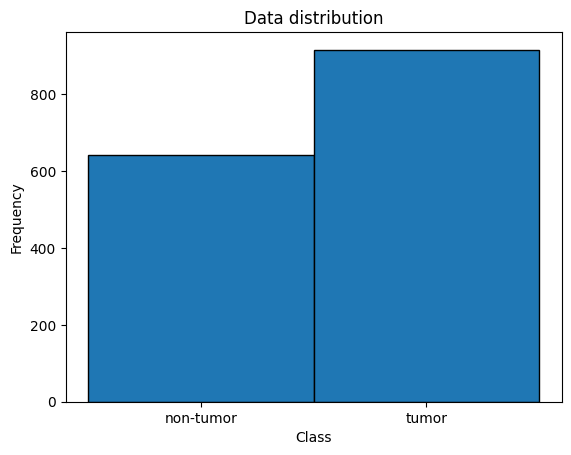

In [146]:
images, labels = [], []

for image, label in data:
    images.append(image.numpy())  
    labels.append(label.numpy())  

images = np.array(images) 
labels = np.array(labels)

indices = np.arange(len(labels))
np.random.seed(42)
np.random.shuffle(indices)

images = images[indices]
labels = labels[indices]

plt.hist(labels, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['non-tumor', 'tumor'])
plt.title("Data distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [147]:
print(f'Number of images in the dataset: {len(data)}')

Number of images in the dataset: 1557


### Display sample ultrasound images from the dataset

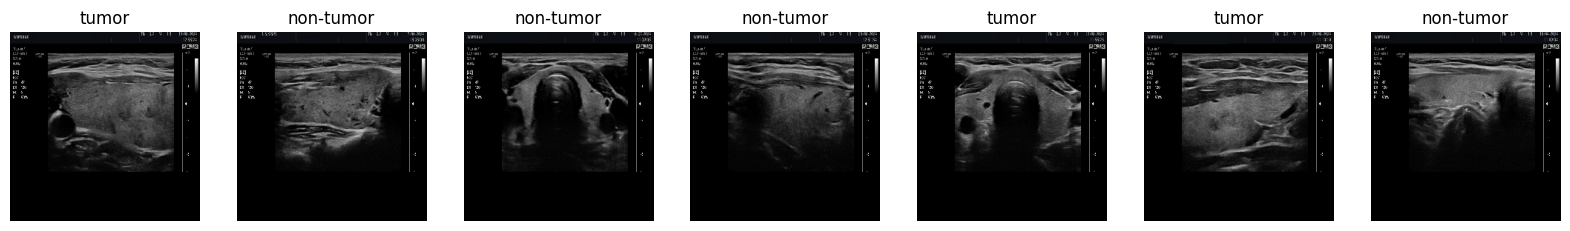

In [148]:
fig, ax = plt.subplots(ncols=7, figsize=(20, 20))

for idx in range(7):
    ax[idx].imshow(images[idx].astype(int))
    
    if labels[idx] == 0:
        ax[idx].title.set_text("non-tumor")
    else:
        ax[idx].title.set_text("tumor")
    
    ax[idx].axis('off')

plt.show()

# Data preprocessing

### Cropping images

In [9]:
# Define input and output directories
input_directory = "dataset/wszystko"
output_directory = "dataset/cropped"

# Create output directory if tt doesn't exist
os.makedirs(output_directory, exist_ok=True)

def crop_image(image):
    # Crop the image: left, upper, right, lower
    return image.crop((220, 90, 1080, 700))

# Process and save cropped images while preserving folder structure
for file_path in data.file_paths:
    image = Image.open(file_path)
    cropped_image = crop_image(image)
    relative_path = os.path.relpath(file_path, input_directory)
    output_path = os.path.join(output_directory, relative_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cropped_image.save(output_path)

print("Finished cropping all images, preserved folder structure.")

Finished cropping all images, preserved folder structure.


In [4]:
data = tf.keras.utils.image_dataset_from_directory("dataset/cropped", labels = 'inferred', label_mode = 'int', class_names = ['clear', 'tumor'], batch_size = None, shuffle = False)

Found 1557 files belonging to 2 classes.


2024-10-25 07:49:50.338824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22232 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


### Display sample cropped images

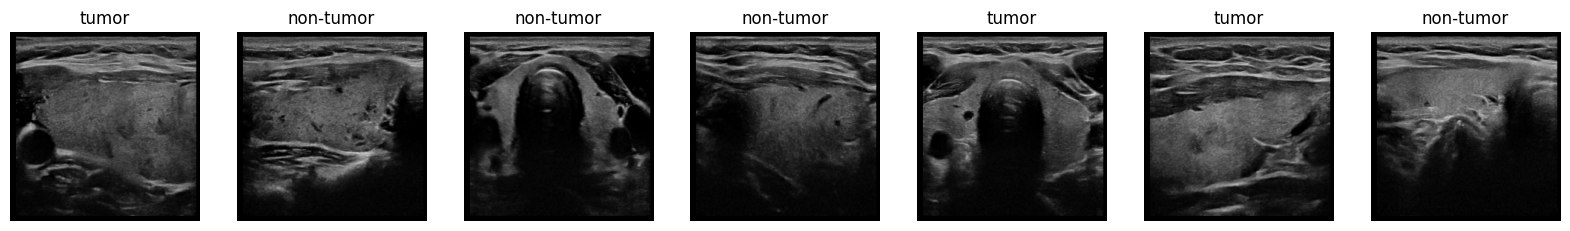

In [5]:
images, labels = [], []

for image, label in data:
    images.append(image.numpy())  
    labels.append(label.numpy())  

images = np.array(images) 
labels = np.array(labels)

indices = np.arange(len(labels))
np.random.seed(42)
np.random.shuffle(indices)

images = images[indices]
labels = labels[indices]

fig, ax = plt.subplots(ncols=7, figsize=(20, 20))

for idx in range(7):
    ax[idx].imshow(images[idx].astype(int))
    
    if labels[idx] == 0:
        ax[idx].title.set_text("non-tumor")
    else:
        ax[idx].title.set_text("tumor")
    
    ax[idx].axis('off')

plt.show()

### Directory Verification and Cleanup

In [151]:
def list_files(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), directory)
            file_list.append(relative_path)
    return sorted(file_list)

# Compare files between input and output directories
input_files = list_files(input_directory)
output_files = list_files(output_directory)
extra_in_output = set(output_files) - set(input_files)

if extra_in_output:
    print("Extra files in output directory:")
    for file in extra_in_output:
        print(file)
else:
    print("No extra files in output directory.")

No extra files in output directory.


In [152]:
for directory in [input_directory, output_directory]:
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            if dir_name == '.ipynb_checkpoints':
                shutil.rmtree(os.path.join(root, dir_name))
                print(f"Removed directory: {os.path.join(root, dir_name)}")

### Data Augmentation

In [7]:
def create_augmentation(brightness_factor, contrast_factor):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomBrightness(factor=brightness_factor),
        tf.keras.layers.RandomContrast(factor=contrast_factor)
    ])

def augment_data(image, label, data_augmentation):
    image = data_augmentation(image)
    return image, label

def create_dataset(images, labels, batch_size, augment=False, data_augmentation=None):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if augment and data_augmentation:
        dataset = dataset.map(lambda x, y: augment_data(x, y, data_augmentation))
    dataset = dataset.map(lambda x, y: (x / 255.0, y))
    dataset = dataset.batch(batch_size)
    return dataset

# Define augmentation parameters
data_augmentation = create_augmentation(brightness_factor=(0.1, 0.15), contrast_factor=(0.1, 0.3))

# Split data into training, validation, and test Sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=1
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=1
)

# Create dataset
batch_size = 10
train_data = create_dataset(train_images, train_labels, batch_size, augment=True, data_augmentation=data_augmentation)
val_data = create_dataset(val_images, val_labels, batch_size)
test_data = create_dataset(test_images, test_labels, batch_size)

In [8]:
# Verify data integrity after splitting
total_samples = sum([y.shape[0] for x, y in train_data]) + \
                sum([y.shape[0] for x, y in val_data]) + \
                sum([y.shape[0] for x, y in test_data])

if total_samples == len(images):
    print("No samples were lost when splitting the data.")
else:
    print("Number of samples does not match.")

No samples were lost when splitting the data.


### Display sample augmented images

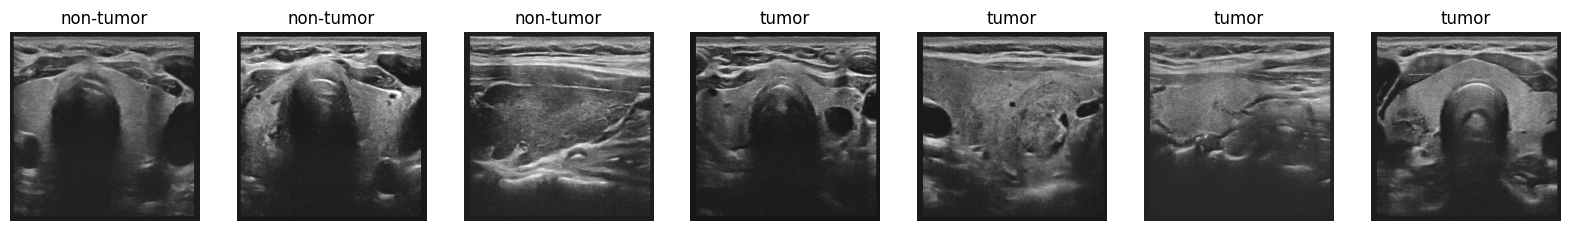

In [155]:
data_iterator = train_data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=7, figsize=(20, 20))

for idx, img in enumerate(batch[0][:7]):
    # Rescaling images back to [0, 255] range for displaying
    ax[idx].imshow((img * 255).astype(int))
    
    if batch[1][idx] == 0:
        ax[idx].title.set_text("non-tumor")
    else:
        ax[idx].title.set_text("tumor")
    
    ax[idx].axis('off')

plt.show()

# Models training

## Custom Convolutional Neural Network (CNN)

In [156]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=35, restore_best_weights=True, min_delta=0.0005)

In [13]:
# Compute class weights to address class imbalance
y_train = np.concatenate([y for x, y in train_data])
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.213450292397661, 1: 0.8504098360655737}


In [11]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation=tf.keras.layers.ReLU(),
                 padding='same', input_shape=(256,256,3),
                 kernel_regularizer=regularizers.l2(0.0002)))
model.add(BatchNormalization())
model.add(MaxPooling2D())


model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, activation=tf.keras.layers.ReLU(), padding='same', kernel_regularizer=regularizers.l2(0.0002)))
model.add(BatchNormalization())
model.add(MaxPooling2D())


model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, activation=tf.keras.layers.ReLU(), padding='same', kernel_regularizer=regularizers.l2(0.0002)))
model.add(BatchNormalization())
model.add(MaxPooling2D())


model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation=tf.keras.layers.ReLU(), padding='same', kernel_regularizer=regularizers.l2(0.0002)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation=tf.keras.layers.ReLU(), kernel_regularizer=regularizers.l2(0.0002)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                      

In [12]:
initial_weights = model.get_weights()

In [ ]:
# Grid search over learning rates
lr_values = np.linspace(0.0001, 0.0005, num=5)
val_acc_comb, test_acc_comb, lr_comb = [], [], []

for lr_rate in lr_values:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    model.set_weights(initial_weights)
    history = model.fit(
        train_data,
        class_weight=class_weight_dict,
        epochs=150,
        validation_data=val_data,
        callbacks=[early_stopping],
        shuffle=True
    )
    max_val_acc = np.max(history.history['val_accuracy'])
    if max_val_acc > 0.7:
        val_acc_comb.append(max_val_acc)
        test_acc = model.evaluate(test_data)[1]
        test_acc_comb.append(test_acc)
        lr_comb.append(lr_rate)
        if max_val_acc > 0.87:
            model.save(f'thyroid_model_new_{lr_rate}.h5')
            with open(f'thyroid_model_history_{lr_rate}.json', 'w') as f:
                json.dump(history.history, f)
    print("\nEvaluating next model\n")

# Display results
print("Validation Accuracies:", val_acc_comb)
print("Learning Rates:", lr_comb)
print("Test Accuracies:", test_acc_comb)

Binary crossentropy was used because there are only 2 classes in the dataset. Adam is used here, because it's great optimizer for image classification. The model is optimized for accuracy during 150 epochs. Early stopping was implemented to restore best weights and data augmentation, l2 regularization, global average pooling and batchnormalization to prevent overfitting.

In [ ]:
# Save results
cnn_df = pd.DataFrame({
    'Learning_rate': lr_comb,
    'Accuracy_validation': val_acc_comb,
    'Accuracy_test': test_acc_comb
})

cnn_df.to_csv('my_cnn_l2_0002_lr_0.00001_to_0.00025.csv', index=False)
print(cnn_df)

In [22]:
# Final training with selected learning rate
selected_lr = 0.00027

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=selected_lr),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

cnn_history = model.fit(
    train_data,
    class_weight=class_weight_dict,
    epochs=150,
    validation_data=val_data,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/150
125/125 [==============================] - 5s 21ms/step - loss: 0.0688 - accuracy: 0.9960 - val_loss: 1.9486 - val_accuracy: 0.6603
Epoch 2/150
125/125 [==============================] - 2s 20ms/step - loss: 0.0713 - accuracy: 0.9952 - val_loss: 1.8457 - val_accuracy: 0.7051
Epoch 3/150
125/125 [==============================] - 2s 19ms/step - loss: 0.0659 - accuracy: 0.9976 - val_loss: 2.2818 - val_accuracy: 0.6346
Epoch 4/150
125/125 [==============================] - 2s 19ms/step - loss: 0.0593 - accuracy: 0.9992 - val_loss: 1.6446 - val_accuracy: 0.6859
Epoch 5/150
125/125 [==============================] - 3s 21ms/step - loss: 0.0686 - accuracy: 0.9960 - val_loss: 6.3416 - val_accuracy: 0.4615
Epoch 6/150
125/125 [==============================] - 2s 19ms/step - loss: 0.0714 - accuracy: 0.9976 - val_loss: 1.6133 - val_accuracy: 0.6603
Epoch 7/150
125/125 [==============================] - 2s 20ms/step - loss: 0.0750 - accuracy: 0.9952 - val_loss: 2.0683 - val_accuracy:

### Evaluate and save the final model

In [23]:
model.evaluate(val_data)

16/16 [==============================] - 0s 6ms/step - loss: 1.5352 - accuracy: 0.7244


[1.5351901054382324, 0.7243589758872986]

In [24]:
model.evaluate(test_data)

16/16 [==============================] - 0s 5ms/step - loss: 1.1959 - accuracy: 0.7372


[1.1958695650100708, 0.7371794581413269]

In [25]:
model.save('thyroid_model.h5')
with open('train_history.json', 'w') as f:
   json.dump(cnn_history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Transfer Learning with VGG16

In [160]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=20,        
                               mode='max',        
                               restore_best_weights=True)

In [161]:
# Load pretrained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Build transfer learning model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
predictions = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs=base_model.input, outputs=predictions)
initial_weights = transfer_model.get_weights()

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# Grid search over learning rates for VGG16 model
val_acc_comb, test_acc_comb, lr_comb = [], [], []
brightness_factors = (0.1, 0.15)
contrast_factors = (0.1, 0.3)
lr_values = np.linspace(0.00004, 0.000045, num=10)
data_augmentation = create_augmentation(brightness_factors, contrast_factors)
train_dataset = create_dataset(train_images, train_labels, batch_size, augment=True, data_augmentation=data_augmentation)
val_dataset = create_dataset(val_images, val_labels, batch_size)
test_dataset = create_dataset(test_images, test_labels, batch_size)

for lr_rate in lr_values:
    print(f"\nEvaluating next model with brightness_factor={brightness_factors}, contrast_factor={contrast_factors}, learning_rate={lr_rate}\n")
    transfer_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    transfer_model.set_weights(initial_weights)
    history = transfer_model.fit(
        train_dataset,
        epochs=70,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        shuffle=True
    )
    max_val_acc = np.max(history.history['val_accuracy'])
    if max_val_acc > 0.8:
        val_acc_comb.append(max_val_acc)
        test_acc = transfer_model.evaluate(test_dataset)[1]
        test_acc_comb.append(test_acc)
        lr_comb.append(lr_rate)
        if max_val_acc > 0.89 and test_acc > 0.89:
            model_filename = f'vgg16_model_lr{lr_rate}.h5'
            history_filename = f'vgg16_history_lr{lr_rate}.json'
            transfer_model.save(model_filename)
            with open(history_filename, 'w') as f:
                json.dump(history.history, f)

# Display results
print("Validation Accuracies:", val_acc_comb)
print("Learning Rates:", lr_comb)
print("Test Accuracies:", test_acc_comb)

In [ ]:
vgg_df = pd.DataFrame({
    'Learning_rate': lr_comb,
    'Accuracy_validation': val_acc_comb,
    'Accuracy_test': test_acc_comb
})
# vgg_df.to_csv('vgg16_l2_0001_comb2.csv', index=False)
print(vgg_df)

In [ ]:
best_lr = 0.000042
data_augmentation = create_augmentation(brightness_factors, contrast_factors)
train_dataset = create_dataset(train_images, train_labels, batch_size, augment=True, data_augmentation=data_augmentation)
val_dataset = create_dataset(val_images, val_labels, batch_size)
test_dataset = create_dataset(test_images, test_labels, batch_size)

transfer_model.set_weights(initial_weights)

# Compile the model with the best learning rate
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = transfer_model.fit(
    train_data,
    epochs=150,
    validation_data=val_data,
    callbacks=[early_stopping],
    shuffle=True
)

# Evaluate the model on the test dataset
test_loss, test_acc = transfer_model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")

In [ ]:
# # Save the trained model
# model_filename = 'models/vgg16_model.h5'
# transfer_model.save(model_filename)

# # Save the training history
# history_filename = 'models/vgg16_history.json'
# with open(history_filename, 'w') as f:
#     json.dump(history.history, f)
# print(f"Training history saved as {history_filename}")

### Model evaluation and visualization

In [183]:
# Load best model and training history
with open('models/vgg16_history.json', 'r') as f:
    history = json.load(f)
model_vgg16 = load_model('models/vgg16_model.h5')
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

Extracting features from flatten layer

In [184]:
feature_extractor = Model(inputs=model_vgg16.input, outputs=model_vgg16.get_layer('global_average_pooling2d_2').output)

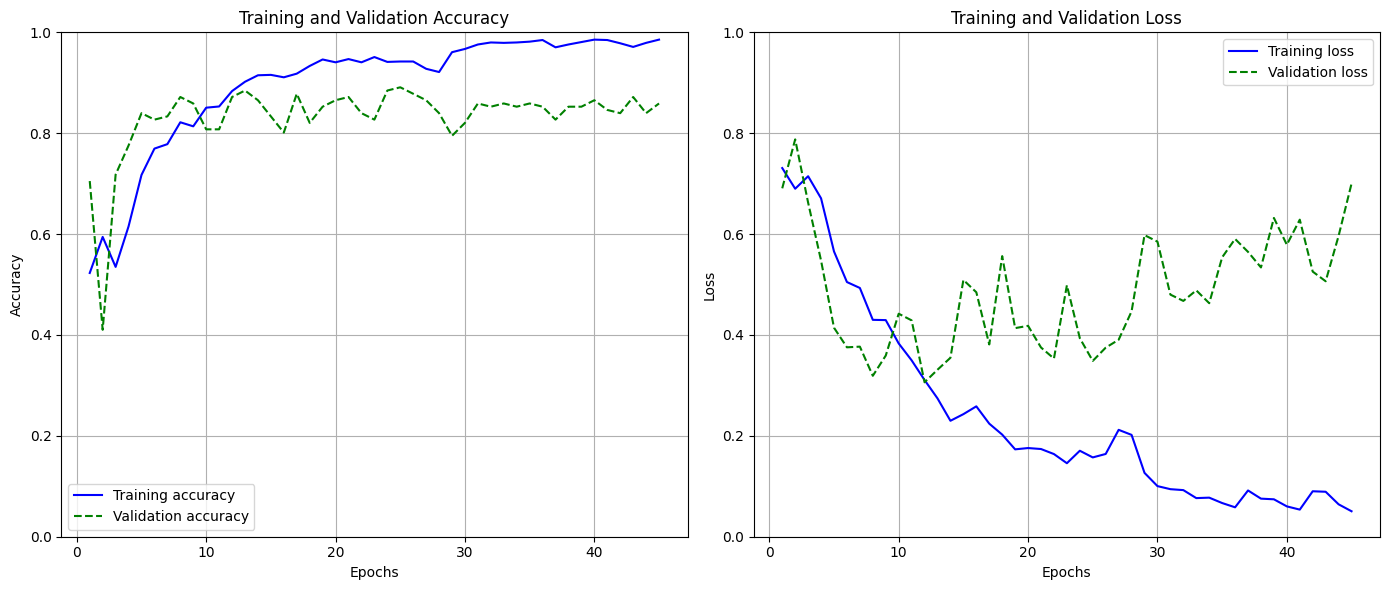

In [185]:
def plot_epochs(model_history, train_metric, val_metric, ax):
    train_met = model_history[train_metric]
    val_met = model_history[val_metric]
    epochs = range(1, len(train_met) + 1)
    ax.plot(epochs, train_met, 'b-', label=f'Training {train_metric}')
    ax.plot(epochs, val_met, 'g--', label=f'Validation {train_metric}')
    ax.set_title(f'Training and Validation {train_metric.capitalize()}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(train_metric.capitalize())
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_epochs(history, 'accuracy', 'val_accuracy', axes[0])
plot_epochs(history, 'loss', 'val_loss', axes[1])

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

The training and validation accuracy are increasing during epochs. Validation accuracy same as its loss is not chaning uniformly at all. The validation accuracy level varies around 90%

In [186]:
# Evaluate model on validation set
Y_val, Y_val_pred = [], []
for x, y in val_data:
    y_pred = (model_vgg16.predict(x) >= 0.5).astype(int)
    Y_val.append(y)
    Y_val_pred.append(y_pred)
Y_val = np.concatenate(Y_val)
Y_val_pred = np.concatenate(Y_val_pred).reshape(-1)
val_accuracy = np.mean(Y_val == Y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.3f}")
model_vgg16.evaluate(val_data)

1/1 [==============================] - 0s 24ms/step
Validation Accuracy: 0.923
16/16 [==============================] - 0s 19ms/step - loss: 0.2957 - accuracy: 0.9231


[0.29570215940475464, 0.9230769276618958]

In [187]:
# Evaluate model on test set
Y_test, Y_test_pred = [], []
for x, y in test_data:
    y_pred = (model_vgg16.predict(x) >= 0.5).astype(int)
    Y_test.append(y)
    Y_test_pred.append(y_pred)
Y_test = np.concatenate(Y_test)
Y_test_pred = np.concatenate(Y_test_pred).reshape(-1)
test_accuracy = np.mean(Y_test == Y_test_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")
model_vgg16.evaluate(test_data)

1/1 [==============================] - 0s 24ms/step
Test Accuracy: 0.955
16/16 [==============================] - 0s 19ms/step - loss: 0.1417 - accuracy: 0.9551


[0.14166945219039917, 0.9551281929016113]

### Plot confusion matrices

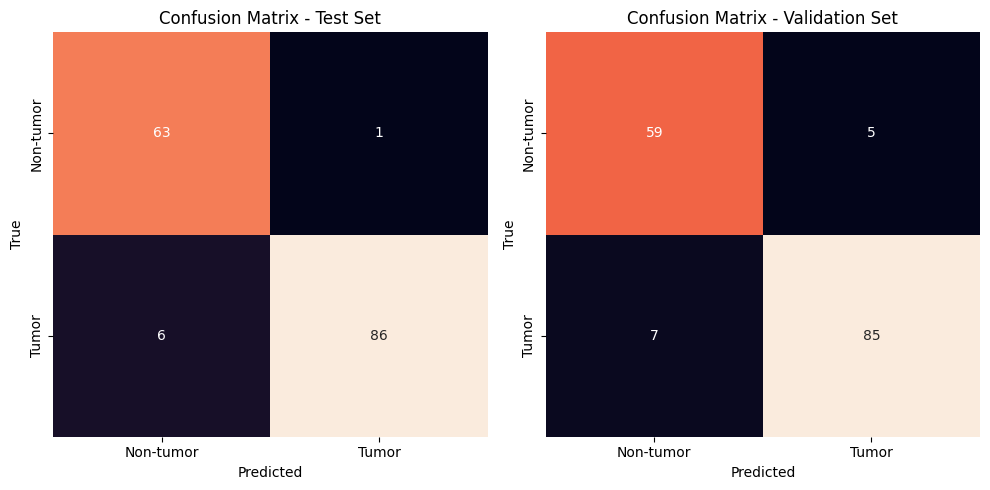

In [88]:
def plot_confusion_matrix_ax(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-tumor', 'Tumor']
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(Y_val, Y_val_pred, "Confusion Matrix - Validation Set", ax=axes[1])
plot_confusion_matrix_ax(Y_test, Y_test_pred, "Confusion Matrix - Test Set", ax=axes[0])
plt.tight_layout()
plt.show()

Combined Accuracy: 0.939
ROC AUC Score: 0.941
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       128
           1       0.97      0.93      0.95       184

    accuracy                           0.94       312
   macro avg       0.93      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312



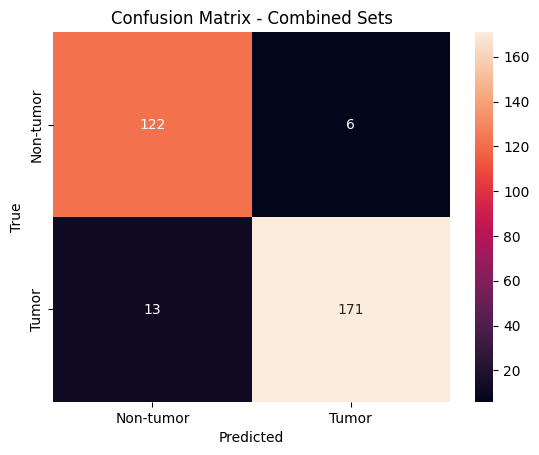

In [68]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-tumor', 'Tumor']
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# Combined evaluation
Y_all_true = np.concatenate([Y_test, Y_val])
Y_all_pred = np.concatenate([Y_test_pred, Y_val_pred])
combined_accuracy = np.mean(Y_all_true == Y_all_pred)
print(f"Combined Accuracy: {combined_accuracy:.3f}")
print(f"ROC AUC Score: {roc_auc_score(Y_all_true, Y_all_pred):.3f}")
print(classification_report(Y_all_true, Y_all_pred))
plot_confusion_matrix(Y_all_true, Y_all_pred, "Confusion Matrix - Combined Sets")

Calculated Confusion matrix for VGG16 shows that it works well. 19 out of 312 observations were misclassified.

Almost every metric is great for VGG16 model on combined test and validation set

## Random Forest Classifier

### Preparation of the train data for Random Forest

In [69]:
data_RF_train = []
y_train = []

for x_batch, y_batch in train_data:
    features = feature_extractor.predict(x_batch)
    #features = features.reshape(features.shape[0], -1)
    data_RF_train.append(features)
    y_train.append(y_batch)

data_RF_train = np.concatenate(data_RF_train)
y_train = np.concatenate(y_train)

1/1 [==============================] - 0s 218ms/step


In [70]:
RF = RandomForestClassifier(class_weight=class_weight_dict, random_state=1)

### Hyperparameters used for tuning Random Forest with Bayes Search

In [71]:
param_space = {
    'n_estimators': Categorical([500,1000,1500,2000, 2500, 3000]),
    'max_features': Categorical(['sqrt', 'log2']),
    'max_depth': Categorical([5,7,9,10, 11, 12]),
    'criterion': Categorical(['gini', 'entropy'])
}
bayes_rf = BayesSearchCV(RF, param_space, n_iter=40, cv=5, scoring='accuracy', n_jobs=-1)

In [72]:
bayes_rf.fit(data_RF_train, y_train)

BayesSearchCV(cv=5,
              estimator=RandomForestClassifier(class_weight={0: 1.213450292397661,
                                                             1: 0.8504098360655737},
                                               random_state=1),
              n_iter=40, n_jobs=-1, scoring='accuracy',
              search_spaces={'criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                             'max_depth': Categorical(categories=(5, 7, 9, 10, 11, 12), prior=None),
                             'max_features': Categorical(categories=('sqrt', 'log2'), prior=None),
                             'n_estimators': Categorical(categories=(500, 1000, 1500, 2000, 2500, 3000), prior=None)})

In [73]:
results = bayes_rf.cv_results_
mean_scores = []
std_scores = []
params_list = []


for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    mean_scores.append(mean)
    std_scores.append(std)
    params_list.append(params)
df_rf = pd.DataFrame(params_list)
df_rf['mean_test_score'] = mean_scores
df_rf['std_test_score'] = std_scores
df_rf.to_csv('models/rf_hist.csv')

In [74]:
df_rf

,criterion,max_depth,max_features,n_estimators,mean_test_score,std_test_score
0,entropy,10,sqrt,500,0.947791,0.015450
1,entropy,11,log2,2500,0.947791,0.015027
2,entropy,11,log2,2500,0.947791,0.015027
3,entropy,11,log2,3000,0.947791,0.015027
4,gini,10,sqrt,2000,0.942972,0.018561
5,entropy,11,sqrt,1500,0.946988,0.015112
6,entropy,11,log2,2500,0.947791,0.015027
7,entropy,5,sqrt,1000,0.946988,0.013772
8,gini,9,log2,2000,0.943775,0.015450
9,entropy,11,log2,3000,0.947791,0.015027


In [75]:
bayes_rf.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 9),
             ('max_features', 'sqrt'),
             ('n_estimators', 500)])

Random Forest saving

In [76]:
dump(bayes_rf, 'models/rf_model.joblib')

['new_models/rf_model.joblib']

Random Forest loading

In [77]:
rf_model = load('models/rf_model.joblib')

In [78]:
rf_model.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 9),
             ('max_features', 'sqrt'),
             ('n_estimators', 500)])

### Test data preparation for Random Forest

In [79]:
data_RF_val = []
y_val = []

for x_batch, y_batch in val_data:
    features = feature_extractor.predict(x_batch)
    data_RF_val.append(features)
    y_val.append(y_batch.numpy())

data_RF_val = np.concatenate(data_RF_val)
y_val = np.concatenate(y_val)

1/1 [==============================] - 0s 26ms/step


In [80]:
data_RF_test = []
y_test = []

for x_batch, y_batch in test_data:
    features = feature_extractor.predict(x_batch)
    data_RF_test.append(features)
    y_test.append(y_batch.numpy())

data_RF_test = np.concatenate(data_RF_test)
y_test = np.concatenate(y_test)

1/1 [==============================] - 0s 23ms/step


In [81]:
pred_RF_val = rf_model.predict(data_RF_val)

In [82]:
prediction_RF = rf_model.predict(data_RF_test)

In [83]:
acc_val = accuracy_score(pred_RF_val, y_val)
acc_test = accuracy_score(prediction_RF, y_test)

print(f"Validation Accuracy: {acc_val:.2%}")
print(f"Test Accuracy: {acc_test:.2%}")

Validation Accuracy: 92.31%
Test Accuracy: 95.51%


In [84]:
print(classification_report(y_test, prediction_RF))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        64
           1       1.00      0.92      0.96        92

    accuracy                           0.96       156
   macro avg       0.95      0.96      0.95       156
weighted avg       0.96      0.96      0.96       156



In [85]:
print(classification_report(y_val, pred_RF_val))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        64
           1       0.94      0.92      0.93        92

    accuracy                           0.92       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.92      0.92      0.92       156



### Confusion Matrix of Random Forest

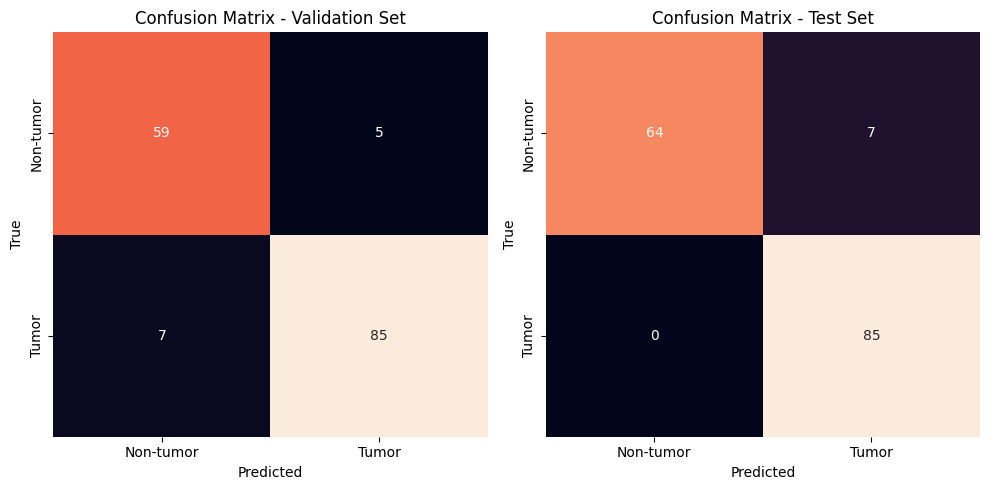

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(y_val, pred_RF_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax(prediction_RF, y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

### Total accuracy for combined test and validation data (312 observations)

In [90]:
print(f'Total accuracy: {(acc_test*len(y_test)+acc_val*len(y_val))/(len(y_test)+len(y_val)):.2%}')

Total accuracy: 93.91%


As we can see almost every metric is good/decent for RF model based on both validation and test data

In [91]:
shape = pred_RF_val.shape[0] + prediction_RF.shape[0]

In [92]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:y_test.shape[0]]=prediction_RF
y_all_pred[y_test.shape[0]:]=pred_RF_val
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:y_test.shape[0]]=y_test
y_all_emp[y_test.shape[0]:]=y_val

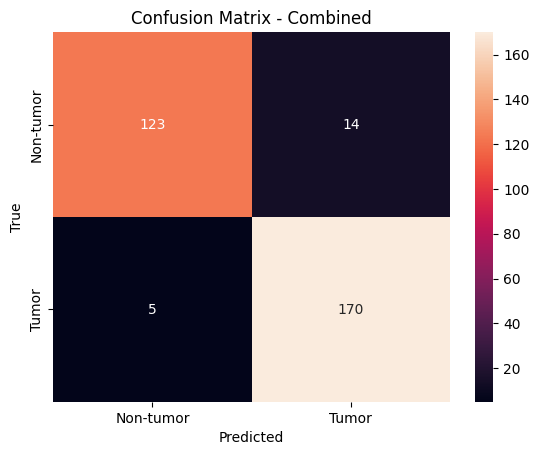

<Figure size 640x480 with 0 Axes>

In [96]:
plot_confusion_matrix(y_all_pred, y_all_emp, "Confusion Matrix - Combined")
plt.tight_layout()
plt.show()

In [97]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC score: {roc_auc_score(y_all_emp, y_all_pred):.2%}')

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       128
         1.0       0.97      0.92      0.95       184

    accuracy                           0.94       312
   macro avg       0.93      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312

ROC AUC score: 94.24%


## XGBoost

In [99]:
data_xgb_train = []
y_train = []

for x_batch, y_batch in train_data:
    features = feature_extractor.predict(x_batch)
    data_xgb_train.append(features)
    y_train.append(y_batch.numpy())

data_xgb_train = np.concatenate(data_xgb_train)
y_train = np.concatenate(y_train)

1/1 [==============================] - 0s 25ms/step


In [100]:
data_xgb_val = []
y_val = []

for x_batch, y_batch in val_data:
    features = feature_extractor.predict(x_batch)
    data_xgb_val.append(features)
    y_val.append(y_batch.numpy())

data_xgb_val = np.concatenate(data_xgb_val)
y_val = np.concatenate(y_val)

1/1 [==============================] - 0s 23ms/step


In [101]:
data_xgb_test = []
y_test = []

for x_batch, y_batch in test_data:
    features = feature_extractor.predict(x_batch)
    data_xgb_test.append(features)
    y_test.append(y_batch.numpy())

data_xgb_test = np.concatenate(data_xgb_test)
y_test = np.concatenate(y_test)

1/1 [==============================] - 0s 30ms/step


In [102]:
class_weight_dict

{0: 1.213450292397661, 1: 0.8504098360655737}

In [ ]:
param_grid = {
    'n_estimators': [10, 100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 0.9],
#    'colsample_bytree': [0.8, 0.9, 1.0]
}


sample_weights = np.array([class_weight_dict[label] for label in y_train])

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs = -1)
grid_search.fit(data_xgb_train, y_train, **{'sample_weight': sample_weights})

In [104]:
grid_search.predict(data_xgb_val)

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1])

In [105]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 1000,
 'subsample': 0.9}

In [112]:
print(f'Validation accuracy: {(np.mean(model_xgb.predict(data_xgb_val) == y_val)):.2%}')
print(f'Test accuracy: {(np.mean(model_xgb.predict(data_xgb_test) == y_test)):.2%}')

Validation accuracy: 93.59%
Test accuracy: 94.87%


In [110]:
# dump(grid_search, 'models/xgb.joblib')

['new_models/xgb.joblib']

In [111]:
model_xgb = load("models/xgb.joblib")

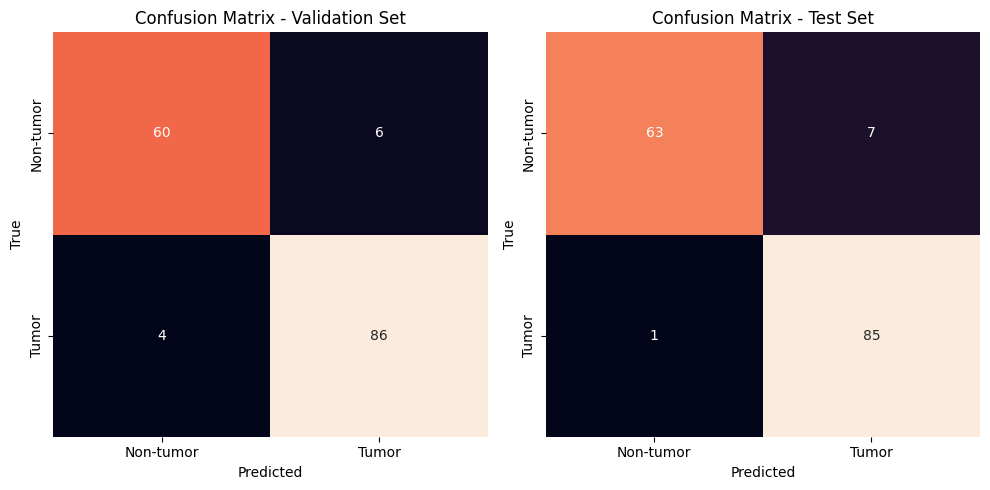

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(model_xgb.predict(data_xgb_val), y_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax(model_xgb.predict(data_xgb_test), y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [114]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:y_test.shape[0]]=model_xgb.predict(data_xgb_test)
y_all_pred[y_test.shape[0]:]=model_xgb.predict(data_xgb_val)
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:y_test.shape[0]]=y_test
y_all_emp[y_test.shape[0]:]=y_val

In [115]:
print(classification_report(y_all_emp,y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       128
         1.0       0.97      0.93      0.95       184

    accuracy                           0.94       312
   macro avg       0.94      0.95      0.94       312
weighted avg       0.94      0.94      0.94       312

ROC AUC Score: 94.51%


## Support Vector Machine Classifier

In [119]:
svm = svm.SVC(probability=True)

In [120]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5], 
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10, 100],  
    'coef0': [0.0, 0.1, 0.5, 1.0],
    'class_weight': ['balanced']
}

In [121]:
grid_search_svm = GridSearchCV(estimator=svm,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [ ]:
grid_search_svm.fit(data_xgb_train, y_train)

In [123]:
grid_search_svm.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'coef0': 1.0,
 'degree': 4,
 'gamma': 0.001,
 'kernel': 'poly'}

In [124]:
print(f'Validation accuracy: {(np.mean(grid_search_svm.predict(data_xgb_val) == y_val)):.2%}')
print(f'Test accuracy: {(np.mean(grid_search_svm.predict(data_xgb_test) == y_test)):.2%}')

Validation accuracy: 92.31%
Test accuracy: 94.23%


In [125]:
# dump(grid_search_svm, "models/svm.joblib")

['new_models/svm.joblib']

In [126]:
model_svm = load("models/svm.joblib")

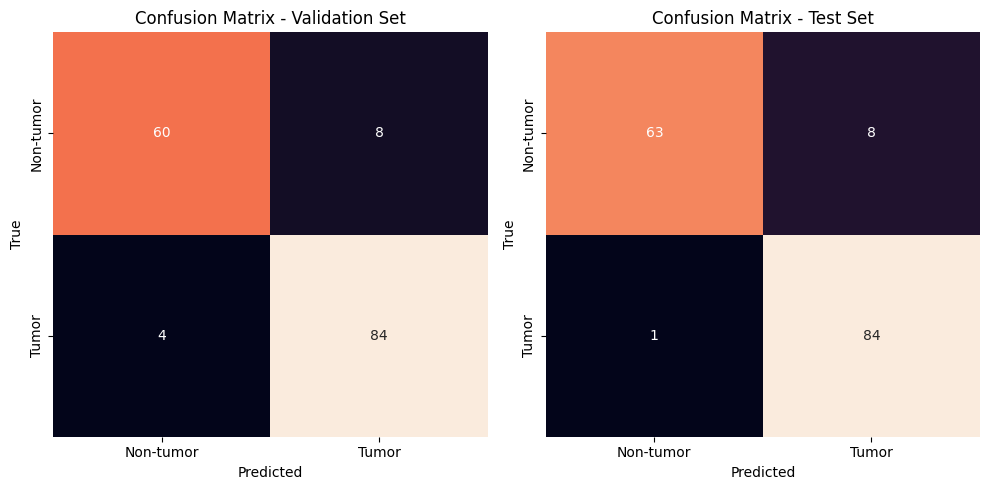

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(model_svm.predict(data_xgb_val), y_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax(model_svm.predict(data_xgb_test), y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [128]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:y_test.shape[0]]=grid_search_svm.predict(data_xgb_test)
y_all_pred[y_test.shape[0]:]=grid_search_svm.predict(data_xgb_val)
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:y_test.shape[0]]=y_test
y_all_emp[y_test.shape[0]:]=y_val

In [129]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       128
         1.0       0.97      0.91      0.94       184

    accuracy                           0.93       312
   macro avg       0.93      0.94      0.93       312
weighted avg       0.94      0.93      0.93       312

ROC AUC Score: 93.70%


## Logistic Regression

In [133]:
lr = LogisticRegression(random_state = 0, max_iter = 100000)

In [134]:
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'solver': ['lbfgs', 'liblinear', 'saga']
}

grid_search_lr = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', verbose=2)

In [ ]:
grid_search_lr.fit(data_xgb_train, y_train)

In [136]:
grid_search_lr.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

In [137]:
print(f'Validation accuracy: {(np.mean(grid_search_lr.predict(data_xgb_val) == y_val)):.2%}')
print(f'Test accuracy: {(np.mean(grid_search_lr.predict(data_xgb_test) == y_test)):.2%}')

Validation accuracy: 92.95%
Test accuracy: 95.51%


In [138]:
# dump(grid_search_lr, "models/LR.joblib")

['new_models/LR.joblib']

In [139]:
model_lr = load("models/LR.joblib")

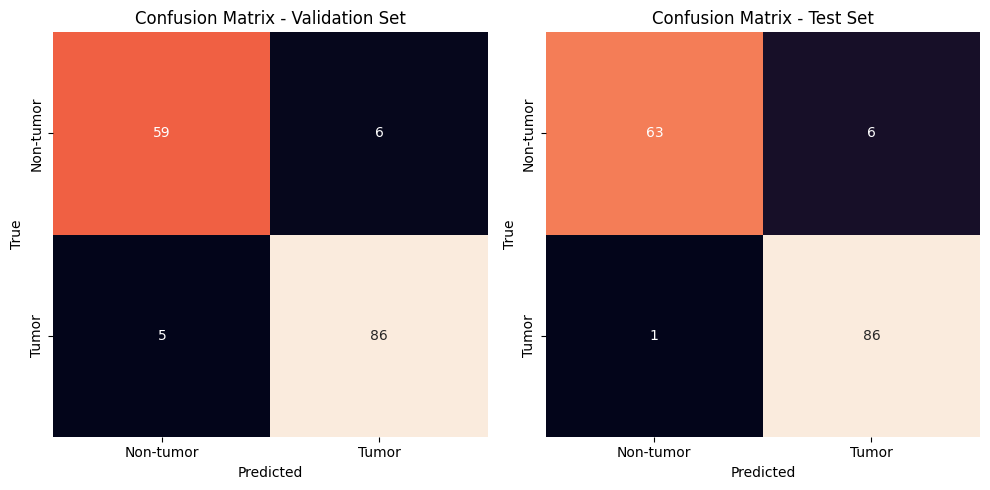

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(model_lr.predict(data_xgb_val), y_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax(model_lr.predict(data_xgb_test), y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [141]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:y_test.shape[0]] = model_lr.predict(data_xgb_test)
y_all_pred[y_test.shape[0]:] = model_lr.predict(data_xgb_val)
y_all_emp = np.zeros(shape=(shape,))
y_all_emp[:y_test.shape[0]] = y_test
y_all_emp[y_test.shape[0]:] = y_val

In [142]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       128
         1.0       0.97      0.93      0.95       184

    accuracy                           0.94       312
   macro avg       0.94      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312

ROC AUC Score: 94.40%


## K-Nearest Neighbours

In [146]:
knn = KNeighborsClassifier()

In [147]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],          
    'weights': ['uniform', 'distance'],        
    'p': [1, 2],                              # Distance metrics (1: Manhattan, 2: Euclidean)
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size': [5, 10, 20, 30, 40, 50]              
}

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose = 1)

In [148]:
grid_search_knn.fit(data_xgb_train, y_train)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [5, 10, 20, 30, 40, 50],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [149]:
print(f'Validation accuracy: {(np.mean(grid_search_knn.predict(data_xgb_val).reshape(-1)==y_val)):.2%}')
print(f'Test accuracy: {(np.mean(grid_search_knn.predict(data_xgb_test).reshape(-1)==y_test)):.2%}')

Validation accuracy: 91.67%
Test accuracy: 94.87%


In [150]:
grid_search_knn.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'n_neighbors': 15,
 'p': 2,
 'weights': 'distance'}

In [151]:
# dump(grid_search_knn, "models/knn.joblib")

['new_models/knn.joblib']

In [152]:
model_knn = load("models/knn.joblib")

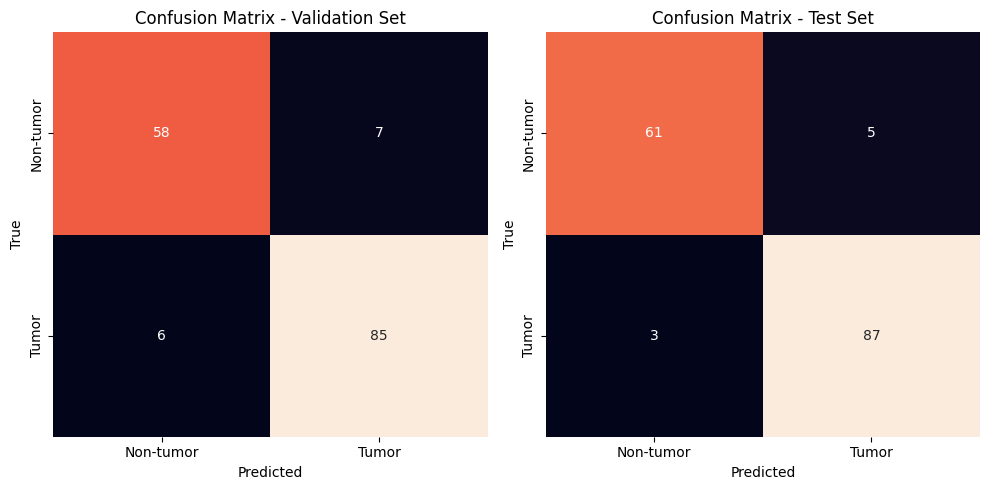

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(model_knn.predict(data_xgb_val), y_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax(model_knn.predict(data_xgb_test), y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [154]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:y_test.shape[0]]=grid_search_knn.predict(data_xgb_test)
y_all_pred[y_test.shape[0]:]=grid_search_knn.predict(data_xgb_val)
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:y_test.shape[0]]=y_test
y_all_emp[y_test.shape[0]:]=y_val

In [155]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       128
         1.0       0.95      0.93      0.94       184

    accuracy                           0.93       312
   macro avg       0.93      0.93      0.93       312
weighted avg       0.93      0.93      0.93       312

ROC AUC Score: 93.22%


## Resnet50

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=30,        
                               mode='max',        
                               restore_best_weights=True)  

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

data_augmentation = create_augmentation(0.2, 0.3)
train_data = create_dataset(train_images, train_labels, batch_size, augment=True, data_augmentation=data_augmentation)
val_data = create_dataset(val_images, val_labels, batch_size)
test_data = create_dataset(test_images, test_labels, batch_size)
    
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])
history = resnet_model.fit(train_data, class_weight=class_weight_dict, epochs=140, validation_data=val_data, callbacks=[early_stopping], shuffle=True)

Epoch 1/140


2024-10-25 07:52:28.314967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-25 07:52:30.846298: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f139101d160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-25 07:52:30.846360: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-10-25 07:52:30.851783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-25 07:52:30.935162: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 [==============================] - 37s 77ms/step - loss: 0.6883 - accuracy: 0.6747 - val_loss: 1.2380 - val_accuracy: 0.4103
Epoch 2/140
125/125 [==============================] - 7s 57ms/step - loss: 0.5080 - accuracy: 0.7679 - val_loss: 3.7629 - val_accuracy: 0.4103
Epoch 3/140
125/125 [==============================] - 7s 57ms/step - loss: 0.4269 - accuracy: 0.8137 - val_loss: 1.7136 - val_accuracy: 0.4103
Epoch 4/140
125/125 [==============================] - 7s 56ms/step - loss: 0.3244 - accuracy: 0.8578 - val_loss: 2.2797 - val_accuracy: 0.4103
Epoch 5/140
125/125 [==============================] - 7s 56ms/step - loss: 0.2764 - accuracy: 0.8972 - val_loss: 2.1751 - val_accuracy: 0.4103
Epoch 6/140
125/125 [==============================] - 7s 56ms/step - loss: 0.2174 - accuracy: 0.9229 - val_loss: 1.8753 - val_accuracy: 0.4103
Epoch 7/140
125/125 [==============================] - 7s 56ms/step - loss: 0.1997 - accuracy: 0.9341 - val_loss: 1.6442 - val_accuracy: 0.4487
Epo

In [18]:
# # Save the model and its history
# resnet_model.save('models/resnet_model.h5')

# with open('models/resnet_training_history.json', 'w') as f:
#     json.dump(history.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# cnn_df = pd.DataFrame(data=np.column_stack([lr_comb,val_acc_comb, test_acc_comb, br_comb, contr_comb]), columns=['Learning_rate', 'Accuracy_validation', 'Accuracy_test', 'Brightness_rate', 'Contrast_ratio'])
# cnn_df.to_csv('models/resnet_l2_0001_lr_0.00001_to_0.00005.csv')
# print(cnn_df)

   Learning_rate  Accuracy_validation  Accuracy_test  Brightness_rate  \
0        0.00004             0.846154       0.865385              0.2   
1        0.00004             0.865385       0.846154              0.2   
2        0.00004             0.871795       0.858974              0.2   
3        0.00004             0.858974       0.820513              0.3   
4        0.00004             0.858974       0.846154              0.3   
5        0.00004             0.846154       0.858974              0.3   

   Contrast_ratio  
0             0.1  
1             0.2  
2             0.3  
3             0.1  
4             0.2  
5             0.3  


In [160]:
resnet_loaded = load_model('models/resnet_model.h5')
with open('models/resnet_training_history.json', 'r') as f:
    history = json.load(f)

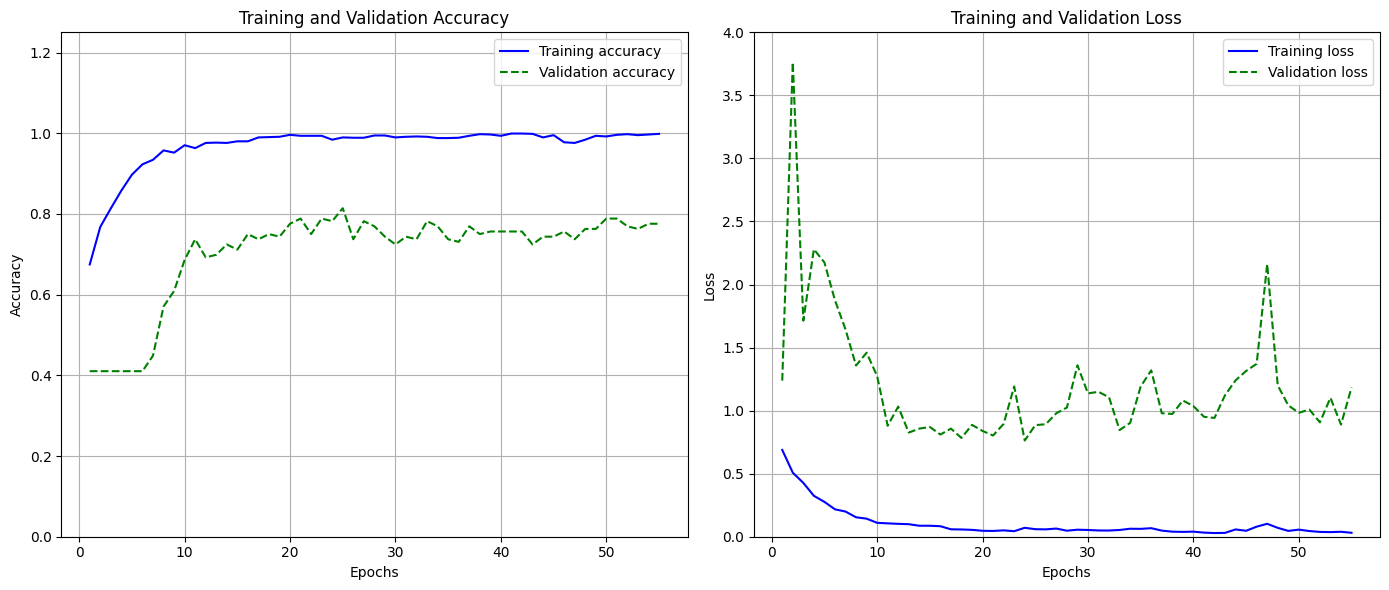

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_epochs(history, 'accuracy', 'val_accuracy', axes[0])
plot_epochs(history, 'loss', 'val_loss', axes[1])

axes[0].set_ylim(0, 1.25)
axes[1].set_ylim(0, 4)

plt.tight_layout()
plt.show()

In [163]:
# Evaluate model on validation set
Y_val, Y_val_pred = [], []
for x, y in val_data:
    y_pred = (resnet_model.predict(x)>=0.5).astype(int)
    Y_val.append(y)
    Y_val_pred.append(y_pred)
Y_val = np.concatenate(Y_val)
Y_val_pred = np.concatenate(Y_val_pred).reshape(-1)
val_accuracy = np.mean(Y_val == Y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.3f}")
resnet_model.evaluate(val_data)

# Evaluate model on test set
Y_test, Y_test_pred = [], []
for x, y in test_data:
    y_pred = (resnet_model.predict(x) >= 0.5).astype(int)
    Y_test.append(y)
    Y_test_pred.append(y_pred)
Y_test = np.concatenate(Y_test)
Y_test_pred = np.concatenate(Y_test_pred).reshape(-1)
test_accuracy = np.mean(Y_test == Y_test_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")
resnet_model.evaluate(test_data)

1/1 [==============================] - 0s 34ms/step
Validation Accuracy: 0.814
1/1 [==============================] - 0s 27ms/step
Test Accuracy: 0.865
16/16 [==============================] - 0s 15ms/step - loss: 0.6543 - accuracy: 0.8654


[0.6542664766311646, 0.8653846383094788]

16/16 [==============================] - 0s 13ms/step


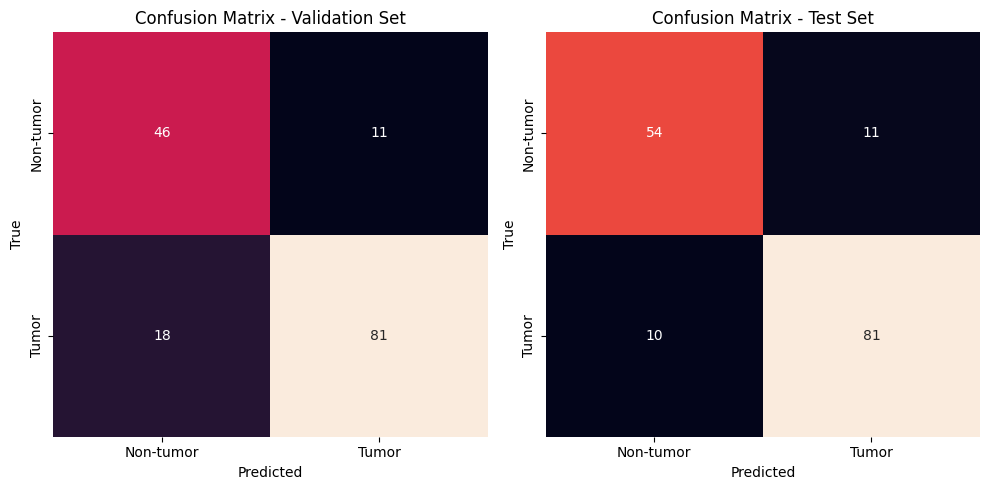

In [164]:
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Non-tumor', 'Tumor']
    sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax((resnet_model.predict(val_data)>=0.5).astype(int), Y_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax((resnet_model.predict(test_data)>=0.5).astype(int), Y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [165]:
Y_test_est = (resnet_model.predict(test_data)>=0.5).astype(int).reshape(-1)
Y_val_est = (resnet_model.predict(val_data)>=0.5).astype(int).reshape(-1)

16/16 [==============================] - 0s 13ms/step


In [166]:
shape = Y_val.shape[0] + Y_test.shape[0]

In [167]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:Y_test.shape[0]]=Y_test_est
y_all_pred[Y_test.shape[0]:]=Y_val_est
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:Y_test.shape[0]]=Y_test
y_all_emp[Y_test.shape[0]:]=Y_val

In [168]:
print(classification_report(y_all_emp, y_all_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       128
         1.0       0.85      0.88      0.87       184

    accuracy                           0.84       312
   macro avg       0.84      0.83      0.83       312
weighted avg       0.84      0.84      0.84       312



## MobileNetV2

In [38]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=20,        
                               mode='max',        
                               restore_best_weights=True)

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(
    128,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.0001)
)(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

val_acc_comb = []
test_acc_comb = []
lr_comb = []
br_comb = []
contr_comb = []


# Brightness and contrast factors
brightness_factors = [0.05, 0.1, 0.15]
contrast_factors = [0.05, 0.1, 0.15]

lr_values = np.linspace(0.00004, 0.00004, num=1)

initial_weights = mobilenet_model.get_weights()

# Hyperparameter tuning loop

for brightness_factor in brightness_factors:
    for contrast_factor in contrast_factors:
        data_augmentation = create_augmentation(brightness_factor, contrast_factor)

        train_dataset = create_dataset(
            train_images,
            train_labels,
            batch_size,
            augment=True,
            data_augmentation=data_augmentation
        )
        val_dataset = create_dataset(val_images, val_labels, batch_size)
        test_dataset = create_dataset(test_images, test_labels, batch_size)

        for lr_rate in lr_values:
            print(f"\nEvaluating model with brightness_factor={brightness_factor}, contrast_factor={contrast_factor}, learning_rate={lr_rate}\n")

            mobilenet_model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy']
            )

            mobilenet_model.set_weights(initial_weights)

            mobilenet_history = mobilenet_model.fit(
                train_dataset,
                epochs=100,
                validation_data=val_dataset,
                callbacks=[early_stopping],
                shuffle=True
            )
            max_val_acc = np.max(mobilenet_history.history['val_accuracy'])
            test_acc = mobilenet_model.evaluate(test_dataset)[1]

            # Store results if validation accuracy exceeds threshold
            if max_val_acc > 0.8:
                val_acc_comb.append(max_val_acc)
                test_acc_comb.append(test_acc)
                lr_comb.append(lr_rate)
                br_comb.append(brightness_factor)
                contr_comb.append(contrast_factor)

                # Save model if both validation and test accuracy exceed 0.89
                if max_val_acc > 0.89 and test_acc > 0.89:
                    model_filename = f'mobilenet_model_lr{lr_rate}_br{brightness_factor}_cr{contrast_factor}.h5'
                    history_filename = f'mobilenet_history_lr{lr_rate}_br{brightness_factor}_cr{contrast_factor}.json'

                    mobilenet_model.save(model_filename)

                    with open(history_filename, 'w') as f:
                        json.dump(mobilenet_history.history, f)

np.set_printoptions(suppress=True)
print("Validation Accuracies:", val_acc_comb)
print("Learning Rates:", lr_comb)
print("Test Accuracies:", test_acc_comb)
print("Brightness Factors:", br_comb)
print("Contrast Factors:", contr_comb)

# Final training with selected hyperparameters
selected_learning_rate = 0.0000625
data_augmentation = create_augmentation(0.15, 0.1)

train_data = create_dataset(
    train_images,
    train_labels,
    batch_size,
    augment=True,
    data_augmentation=data_augmentation
)
val_dataset = create_dataset(val_images, val_labels, batch_size)
test_dataset = create_dataset(test_images, test_labels, batch_size)
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=selected_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

mobilenet_history = mobilenet_model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[early_stopping]
)

In [40]:
# cnn_df = pd.DataFrame(data = np.column_stack([lr_comb,val_acc_comb, test_acc_comb, br_comb, contr_comb]), columns = ['Learning_rate', 'Accuracy_validation', 'Accuracy_test', 'Brightness_rate', 'Contrast_rate'])
# cnn_df.to_csv('mobilenet_l2_0001_lr_0.00005_to_0.0001.csv')
# print(cnn_df)

   Learning_rate  Accuracy_validation  Accuracy_test  Brightness_rate  \
0        0.00007             0.858974       0.788462             0.05   
1        0.00007             0.839744       0.826923             0.05   
2        0.00007             0.833333       0.833333             0.10   
3        0.00007             0.846154       0.839744             0.10   
4        0.00007             0.878205       0.794872             0.10   
5        0.00007             0.814103       0.782051             0.15   
6        0.00007             0.820513       0.846154             0.15   
7        0.00007             0.839744       0.794872             0.15   

   Contrast_rate  
0           0.05  
1           0.10  
2           0.05  
3           0.10  
4           0.15  
5           0.05  
6           0.10  
7           0.15  


In [178]:
model_mobilenet = load_model("models/mobilenet_model.h5")

In [179]:
Y_val_est = (model_mobilenet.predict(val_data)>=0.5).astype(int).reshape(-1)

16/16 [==============================] - 1s 8ms/step


In [180]:
Y_test_est = (model_mobilenet.predict(test_data)>=0.5).astype(int).reshape(-1)

16/16 [==============================] - 0s 8ms/step


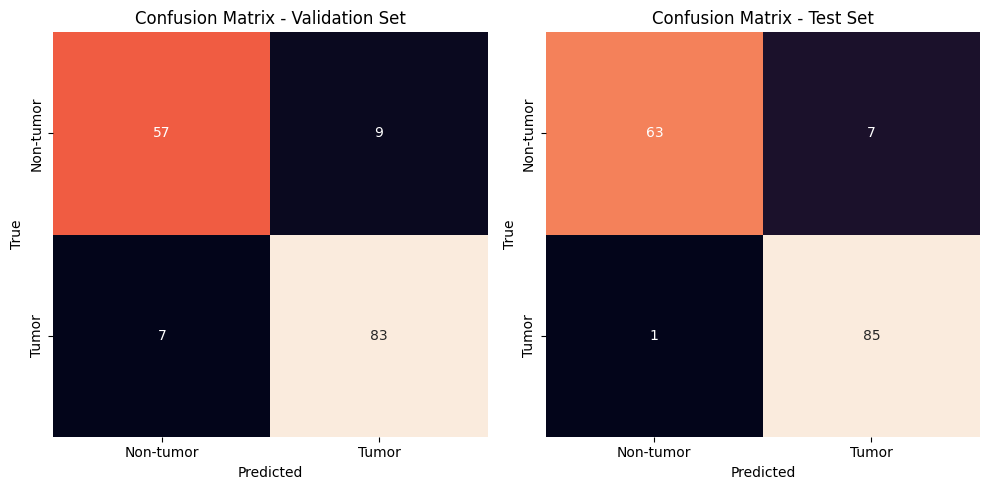

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix_ax(Y_val_est, Y_val, "Confusion Matrix - Validation Set", ax=axes[0])
plot_confusion_matrix_ax(Y_test_est, Y_test, "Confusion Matrix - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [173]:
shape = Y_val.shape[0] + Y_test.shape[0]

In [174]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:Y_test.shape[0]]=Y_test_est
y_all_pred[Y_test.shape[0]:]=Y_val_est
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:Y_test.shape[0]]=Y_test
y_all_emp[Y_test.shape[0]:]=Y_val

In [175]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       128
         1.0       0.95      0.91      0.93       184

    accuracy                           0.92       312
   macro avg       0.92      0.93      0.92       312
weighted avg       0.92      0.92      0.92       312

ROC AUC Score: 92.53%


In [188]:
with open("models/mobilenet_history.json", 'r') as f:
    history = json.load(f)

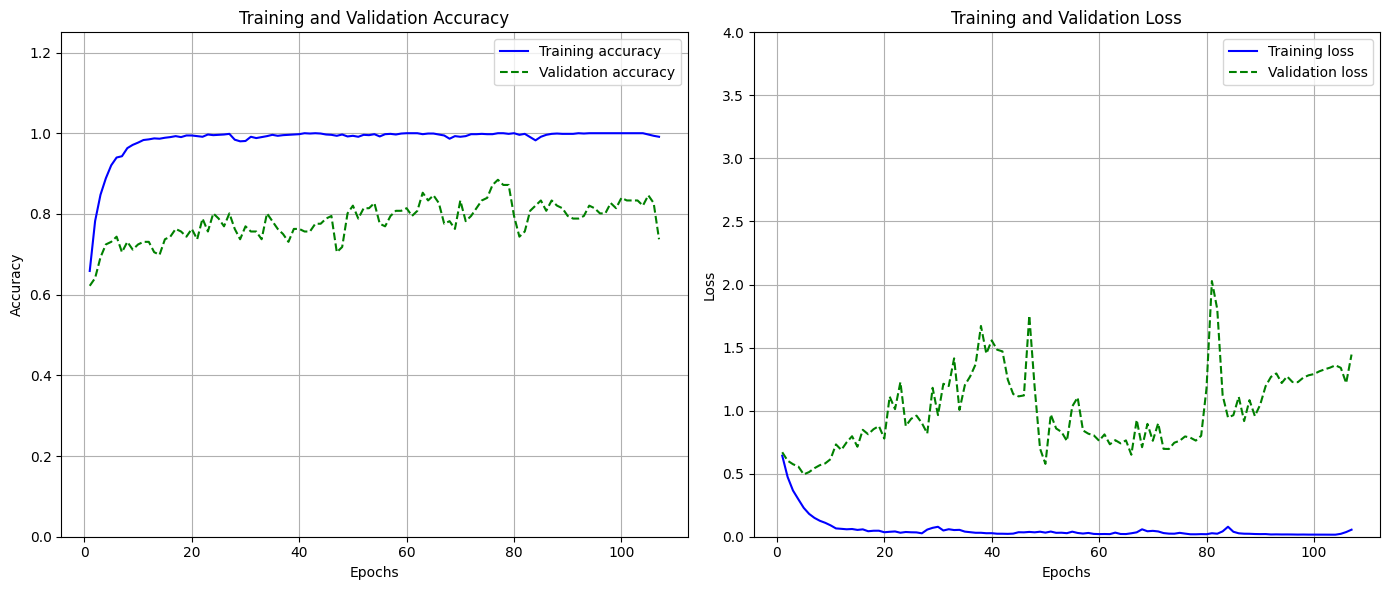

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_epochs(history, 'accuracy', 'val_accuracy', axes[0])
plot_epochs(history, 'loss', 'val_loss', axes[1])

axes[0].set_ylim(0, 1.25)
axes[1].set_ylim(0, 4)

plt.tight_layout()
plt.show()

# Prediction on single photos

Function for predicting single photos, plotting it and printing the outcome

In [65]:
def pred_single(img_path, model):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    resize=cv2.resize(img, (256,256))
    resize = resize / 255.0
    if isinstance(model, skopt.searchcv.BayesSearchCV):
        x_pred = feature_extractor.predict(np.expand_dims(resize, 0))
        yhat = model.predict_proba(x_pred).reshape(-1)[1]
        print(yhat)
        if (yhat < 0.5):
            print("Non-tumor")
        else:
            print("Tumor")
    else:
        x_pred = np.expand_dims(resize,0)
        yhat = model.predict(x_pred).reshape(-1)
        print(yhat)
        if (yhat >= 0.5):
            print("Tumor")
        else:
            print("Non-tumor")

### VGG16 predictions

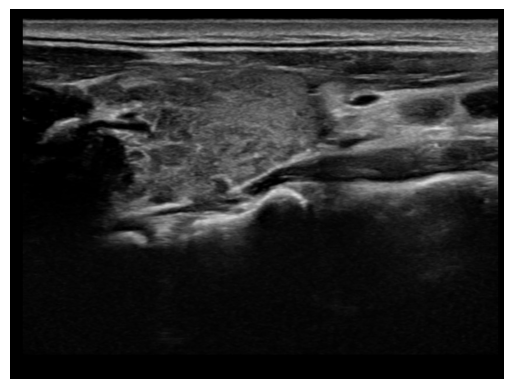

1/1 [==============================] - 0s 20ms/step
[0.10652333]
Non-tumor


In [81]:
pred_single("bez_zmian_bez_oznaczen.JPG", model_vgg16)

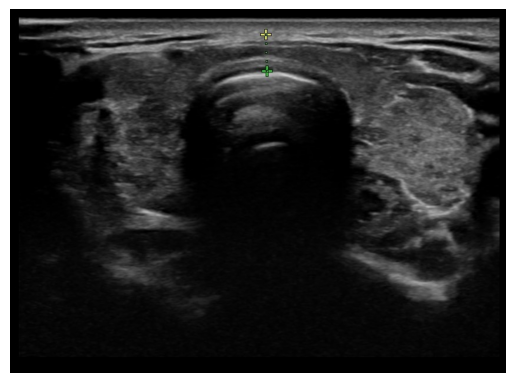

1/1 [==============================] - 0s 21ms/step
[0.6547312]
Tumor


In [82]:
pred_single("bez_zmianowe.JPG", model_vgg16)

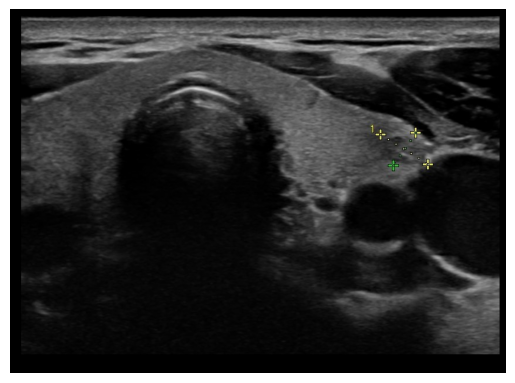

1/1 [==============================] - 0s 22ms/step
[0.80649245]
Tumor


In [83]:
pred_single("guz.JPG", model_vgg16)

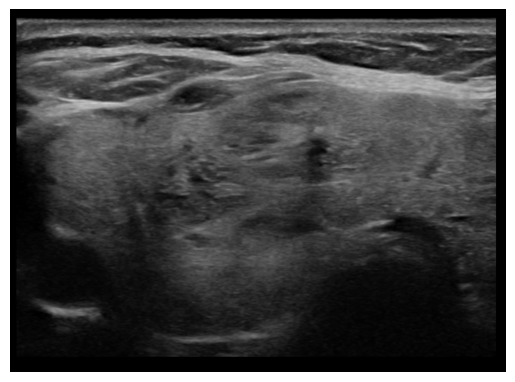

1/1 [==============================] - 0s 22ms/step
[0.9700496]
Tumor


In [84]:
pred_single("guz_bez_oznaczen.jpg", model_vgg16)

# Grad-CAM

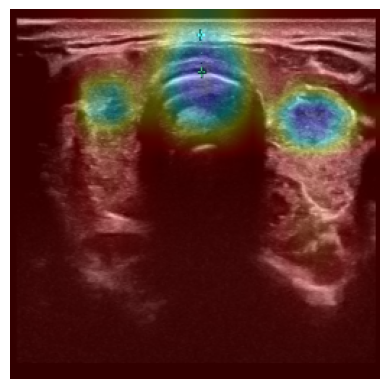

1/1 [==============================] - 0s 240ms/step
Probability of tumor: [[0.00719477]]


In [65]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training = True)
        class_channel = predictions[:, 0]
    
    grads = tape.gradient(class_channel, conv_outputs)
    
    if grads is None:
        raise ValueError("Gradienty są None. Sprawdź, czy model i wejście są poprawnie skonfigurowane.")
    
    grads = tf.abs(grads)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    
    heatmap = np.mean(conv_outputs * pooled_grads[None, None, :], axis=-1) # tu różnica
    
    #print("Heatmap przed normalizacją min:", np.min(heatmap))
    #print("Heatmap przed normalizacją max:", np.max(heatmap))
    
    heatmap = np.maximum(heatmap, 0)
    heatmap_max = np.max(heatmap)
    if heatmap_max > 0:
        heatmap /= heatmap_max
    
    #print("Heatmap po normalizacji min:", np.min(heatmap))
    #print("Heatmap po normalizacji max:", np.max(heatmap))
    
    return heatmap

def display_gradcam(img, heatmap, alpha=0.3):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + (img * 255).astype(np.uint8)
    superimposed_img = np.clip(superimposed_img, 0, 255)
    return superimposed_img / 255.0


model = tf.keras.models.load_model('models/vgg16_model.h5')


img = cv2.imread('bez_zmianowe.JPG', cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255.0  
img_array = np.expand_dims(img, axis=0)  
plt.imshow(img)

heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv3')  

superimposed_img = display_gradcam(img, heatmap)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()
print(f"Probability of tumor: {model.predict(img_array)}")

In [197]:
model_vgg16 = load_model("models/vgg16_model.h5")
model_mobilenet = load_model("models/mobilenet_model.h5")
model_xgb = load("models/xgb.joblib")
model_svm = load("models/svm.joblib")
model_lr = load("models/LR.joblib")
rf_model = load("models/rf_model.joblib")
knn_model = load("models/knn.joblib")

### Saving misclassified images and ploting them

In [204]:
incorrect_images = []
diffs_labels = []
for images, labels in test_data:
    #diffs_indices = np.where((loaded_model.predict(images)>=0.5).astype(int).reshape(-1) != labels)
    z = np.squeeze(labels)
    w = np.squeeze((model_vgg16.predict(images)>=0.5).astype(int).reshape(-1))
    incorrect_indices = np.where(z!=w)[0]
    print(incorrect_indices)
    if len(incorrect_indices) > 0:
            incorrect_images.extend(images.numpy()[incorrect_indices])
incorrect_images = np.array(incorrect_images)

1/1 [==============================] - 0s 114ms/step
[]
1/1 [==============================] - 0s 25ms/step
[0]
1/1 [==============================] - 0s 26ms/step
[]
1/1 [==============================] - 0s 24ms/step
[]
1/1 [==============================] - 0s 25ms/step
[]
1/1 [==============================] - 0s 28ms/step
[]
1/1 [==============================] - 0s 28ms/step
[]
1/1 [==============================] - 0s 25ms/step
[2 9]
1/1 [==============================] - 0s 25ms/step
[]
1/1 [==============================] - 0s 26ms/step
[1]
1/1 [==============================] - 0s 24ms/step
[3]
1/1 [==============================] - 0s 28ms/step
[0 8]
1/1 [==============================] - 0s 25ms/step
[]
1/1 [==============================] - 0s 25ms/step
[]
1/1 [==============================] - 0s 34ms/step
[]
1/1 [==============================] - 0s 23ms/step
[]


In [205]:
wrong_pred = loaded_model.predict(incorrect_images).reshape(-1)

1/1 [==============================] - 0s 25ms/step


In [206]:
wrong_pred

array([0.4414752 , 0.01871961, 0.33251563, 0.07083059, 0.09132869,
       0.04073459, 0.6355574 ], dtype=float32)

In [207]:
mobilenet_pred = model_mobilenet.predict(incorrect_images).reshape(-1)

1/1 [==============================] - 1s 544ms/step


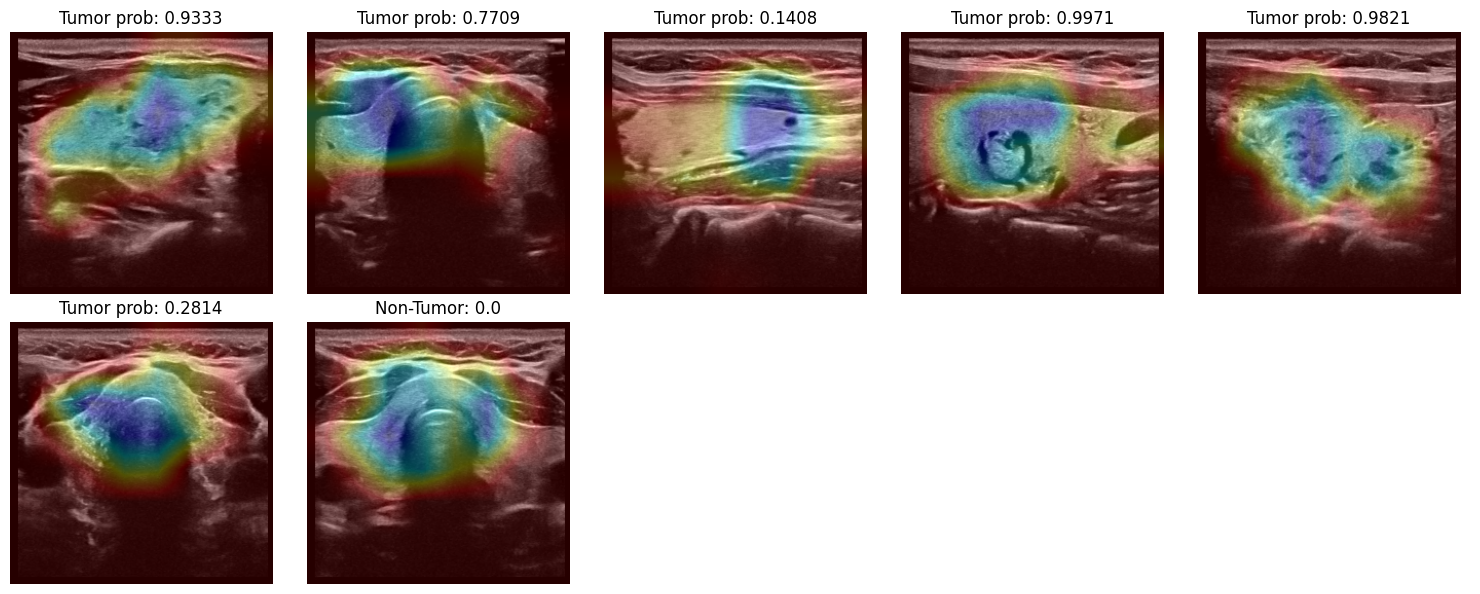

In [208]:
num_images = len(incorrect_images)
cols = 5  
rows = (num_images // cols) + int(num_images % cols != 0)


fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))


for i, img in enumerate(incorrect_images):
    img_array = np.expand_dims(img, axis=0)  
    
    
    heatmap = make_gradcam_heatmap(img_array, model_mobilenet, 'Conv_1')  
    
    superimposed_img = display_gradcam(img, heatmap)
    
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]
    ax.imshow(superimposed_img)
    ax.axis('off')
    
    prob = float(wrong_pred[i])
    mobilenet_prob = float(mobilenet_pred[i])
    if prob >= 0.5:
        rounded_prob = round(mobilenet_prob, 4)
        title = f"Non-Tumor: {rounded_prob}"  
    else:
        rounded_prob = round(mobilenet_prob, 4)
        title = f"Tumor prob: {rounded_prob}"  
    ax.set_title(title)


for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    ax = axes[row, col] if rows > 1 else axes[col]
    ax.axis('off')


plt.tight_layout()
plt.show()

In [209]:
def EnsembleVoting_soft(classifiers, images):
    results = []
    for i in range(len(classifiers)):
        if isinstance(classifiers[i], GridSearchCV) or isinstance(classifiers[i], BayesSearchCV):
            img = feature_extractor.predict(images)
            preds = classifiers[i].predict_proba(img)[:,1]
            results.append(preds)
        else:
            preds = classifiers[i].predict(images).reshape(-1)
            results.append(preds)
    avg_results = (np.mean(results,axis=0)>=0.5).astype(int)
        #print(preds)
    return avg_results

In [210]:
def EnsembleVoting_hard(classifiers, images):
    results = []
    for i in range(len(classifiers)):
        if isinstance(classifiers[i], GridSearchCV) or isinstance(classifiers[i], BayesSearchCV):
            img = feature_extractor.predict(images)
            preds = classifiers[i].predict_proba(img)[:,1]
            results.append(preds)
        else:
            preds = classifiers[i].predict(images).reshape(-1)
            results.append(preds)
    results = np.array(results)
    max_indices = np.argmax(np.abs(results-0.5), axis=0)
    final_results = ((results[max_indices, np.arange(results.shape[1])]>=0.5).astype(int))
        #print(preds)
    return final_results

In [211]:
ensemble_test_soft = EnsembleVoting_soft([loaded_model, grid_search_svm, grid_search_lr, mobilenet_loaded, rf_model, knn_model], test_data)
ensemble_val_soft = EnsembleVoting_soft([loaded_model, grid_search_svm, grid_search_lr, mobilenet_loaded, rf_model, knn_model], val_data)

16/16 [==============================] - 0s 17ms/step


In [212]:
ensemble_test_hard = EnsembleVoting_hard([loaded_model, grid_search_svm, model,  rf_model, grid_search_lr, grid_search, mobilenet_loaded, knn_model], test_data)
ensemble_val_hard = EnsembleVoting_hard([loaded_model, grid_search_svm, model, rf_model, grid_search_lr, grid_search, mobilenet_loaded, knn_model], val_data)

16/16 [==============================] - 0s 16ms/step


In [213]:
print(f'Ensemble hard validation accuracy: {(np.mean(Y_val==ensemble_val_hard)):.2%}')

Ensemble hard validation accuracy: 92.95%


In [214]:
print(f'Ensemble hard test accuracy: {(np.mean(Y_test==ensemble_test_hard)):.2%}')

Ensemble hard test accuracy: 96.79%


In [215]:
print(f'Ensemble soft validation accuracy: {(np.mean(Y_val==ensemble_val_soft)):.2%}')

Ensemble soft validation accuracy: 92.31%


In [216]:
print(f'Ensemble soft test accuracy: {(np.mean(Y_test==ensemble_test_soft)):.2%}')

Ensemble soft test accuracy: 95.51%


In [ ]:
import itertools

def evaluate_ensemble(ensemble_func, classifiers, test_data, val_data):
    test_score = ensemble_func(list(classifiers.values()), test_data)
    val_score = ensemble_func(list(classifiers.values()), val_data)
    
    test_accuracy = accuracy_score(Y_test, test_score)
    val_accuracy = accuracy_score(Y_val, val_score)
    
    return test_accuracy, val_accuracy


voting_methods = [EnsembleVoting_soft, EnsembleVoting_hard]


results_matrix = []


classifiers = {
    'VGG16': model_vgg16,
    'XGB': model_xgb,
    'SVM': model_svm,
    'Logistic Regression': model_lr,
    'MobileNet': model_mobilenet,
    'Random Forest': rf_model,
    'KNN' : knn_model
}

classifier_names = list(classifiers.keys())
classifier_objects = list(classifiers.values())

for r in range(2, len(classifier_objects) + 1):
    for subset in itertools.combinations(zip(classifier_names, classifier_objects), r):
        subset_names, subset_objects = zip(*subset)
        for voting_method in voting_methods:
            test_score, val_score = evaluate_ensemble(voting_method, dict(zip(subset_names, subset_objects)), test_data, val_data)
            
            results_matrix.append({
                'classifiers': subset_names,
                'voting_method': voting_method.__name__,
                'test_score': test_score,
                'val_score': val_score
            })

In [218]:
results = pd.DataFrame(results_matrix)
val_max = results.iloc[:,3].max()
test_max = results.iloc[:,2].max()
results[results['val_score'] == val_max]

,classifiers,voting_method,test_score,val_score
6,"(VGG16, MobileNet)",EnsembleVoting_soft,0.961538,0.935897
7,"(VGG16, MobileNet)",EnsembleVoting_hard,0.961538,0.935897
47,"(VGG16, XGB, MobileNet)",EnsembleVoting_hard,0.961538,0.935897
55,"(VGG16, SVM, MobileNet)",EnsembleVoting_hard,0.961538,0.935897
61,"(VGG16, Logistic Regression, MobileNet)",EnsembleVoting_hard,0.961538,0.935897
67,"(VGG16, MobileNet, Random Forest)",EnsembleVoting_hard,0.961538,0.935897
100,"(SVM, MobileNet, KNN)",EnsembleVoting_soft,0.948718,0.935897
114,"(VGG16, XGB, SVM, MobileNet)",EnsembleVoting_soft,0.955128,0.935897
115,"(VGG16, XGB, SVM, MobileNet)",EnsembleVoting_hard,0.961538,0.935897
120,"(VGG16, XGB, Logistic Regression, MobileNet)",EnsembleVoting_soft,0.955128,0.935897


In [219]:
results[(results['val_score'] == val_max) & (results['test_score'] == test_max)]

,classifiers,voting_method,test_score,val_score


In [220]:
best_test_res = results[results['test_score'] == test_max]
best_val = best_test_res.iloc[:,3].max()
best_scores = best_test_res[best_test_res['val_score'] == best_val]
best_scores

,classifiers,voting_method,test_score,val_score
38,"(MobileNet, KNN)",EnsembleVoting_soft,0.967949,0.929487
39,"(MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
69,"(VGG16, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
89,"(XGB, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
101,"(SVM, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
107,"(Logistic Regression, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
111,"(MobileNet, Random Forest, KNN)",EnsembleVoting_hard,0.967949,0.929487
129,"(VGG16, XGB, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
141,"(VGG16, SVM, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487
147,"(VGG16, Logistic Regression, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487


In [221]:
results['mean_score'] = (results['test_score'] + results['val_score']) / 2
best_scores = results[results['mean_score'] ==results['mean_score'].max()]
best_scores

,classifiers,voting_method,test_score,val_score,mean_score
6,"(VGG16, MobileNet)",EnsembleVoting_soft,0.961538,0.935897,0.948718
7,"(VGG16, MobileNet)",EnsembleVoting_hard,0.961538,0.935897,0.948718
38,"(MobileNet, KNN)",EnsembleVoting_soft,0.967949,0.929487,0.948718
39,"(MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487,0.948718
47,"(VGG16, XGB, MobileNet)",EnsembleVoting_hard,0.961538,0.935897,0.948718
55,"(VGG16, SVM, MobileNet)",EnsembleVoting_hard,0.961538,0.935897,0.948718
61,"(VGG16, Logistic Regression, MobileNet)",EnsembleVoting_hard,0.961538,0.935897,0.948718
67,"(VGG16, MobileNet, Random Forest)",EnsembleVoting_hard,0.961538,0.935897,0.948718
69,"(VGG16, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487,0.948718
89,"(XGB, MobileNet, KNN)",EnsembleVoting_hard,0.967949,0.929487,0.948718


In [222]:
best_scores_hard = results[results['voting_method'] == 'EnsembleVoting_hard']
best_scores_hard = best_scores_hard[best_scores_hard['mean_score'] == best_scores_hard['mean_score'].max()]
best_scores_hard.iloc[15,0]

('VGG16', 'SVM', 'Logistic Regression', 'MobileNet')

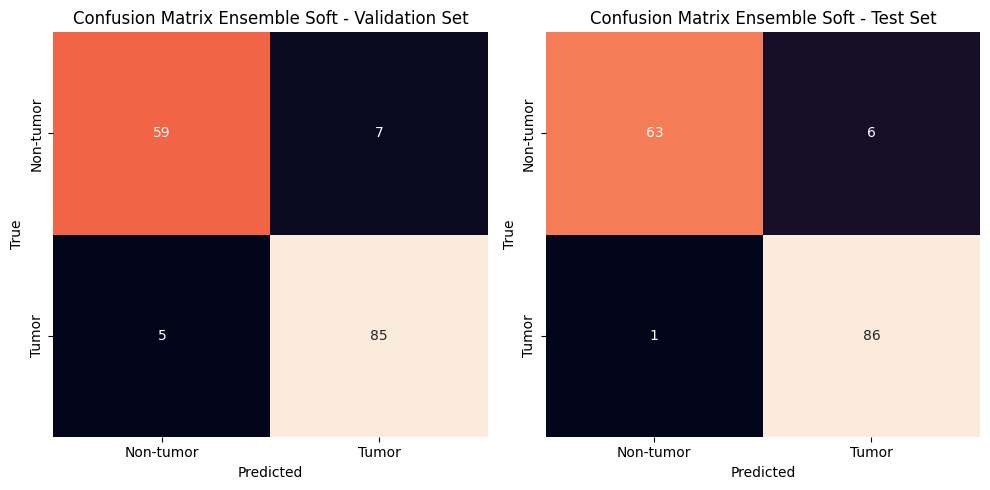

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix(ensemble_val_soft, Y_val, "Confusion Matrix Ensemble Soft - Validation Set", ax=axes[0])
plot_confusion_matrix(ensemble_test_soft, Y_test, "Confusion Matrix Ensemble Soft - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [225]:
shape = Y_val.shape[0] + Y_test.shape[0]

In [226]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:Y_test.shape[0]]=ensemble_test_soft
y_all_pred[Y_test.shape[0]:]=ensemble_val_soft
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:Y_test.shape[0]]=Y_test
y_all_emp[Y_test.shape[0]:]=Y_val

In [227]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93       128
         1.0       0.97      0.93      0.95       184

    accuracy                           0.94       312
   macro avg       0.93      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312

ROC AUC Score: 94.12%


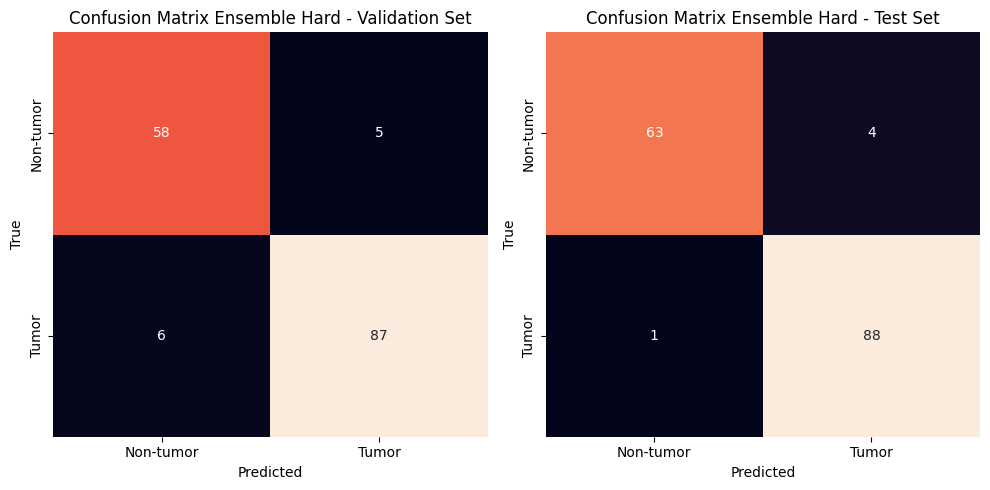

In [228]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_confusion_matrix(ensemble_val_hard, Y_val, "Confusion Matrix Ensemble Hard - Validation Set", ax=axes[0])
plot_confusion_matrix(ensemble_test_hard, Y_test, "Confusion Matrix Ensemble Hard - Test Set", ax=axes[1])
plt.tight_layout()
plt.show()

In [229]:
y_all_pred = np.zeros(shape=(shape,))
y_all_pred[:Y_test.shape[0]]=ensemble_test_hard
y_all_pred[Y_test.shape[0]:]=ensemble_val_hard
y_all_emp =np.zeros(shape=(shape,))
y_all_emp[:Y_test.shape[0]]=Y_test
y_all_emp[Y_test.shape[0]:]=Y_val

In [230]:
print(classification_report(y_all_emp, y_all_pred))
print(f'ROC AUC Score: {(roc_auc_score(y_all_emp, y_all_pred)):.2%}')

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       128
         1.0       0.96      0.95      0.96       184

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312

ROC AUC Score: 94.82%


In [233]:
EnsembleVoting_soft([model_vgg16, model_xgb, model_svm, model_lr, model_mobilenet, rf_model, knn_model], incorrect_images) == (wrong_pred>=0.5).astype(int)

1/1 [==============================] - 0s 23ms/step


array([False,  True,  True,  True,  True,  True,  True])

In [234]:
EnsembleVoting_hard([model_vgg16, model_xgb, model_svm, model_lr, model_mobilenet, rf_model, knn_model], incorrect_images) == (wrong_pred>=0.5).astype(int)

1/1 [==============================] - 0s 22ms/step


array([False,  True,  True, False, False,  True, False])

In [148]:
img_pred = []
img_paths = ["bez_zmian_bez_oznaczen.JPG", "bez_zmianowe.JPG", "guz_bez_oznaczen.jpg", "guz.JPG"]
for i in img_paths:
    img = cv2.imread(i, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256)) / 255.0  
    img_array = np.expand_dims(img, axis=0)
    img_pred.append(img_array)
img_pred = np.concatenate(img_pred)
pred = EnsembleVoting_hard([model_vgg16, model_xgb, model_svm, model_lr, model_mobilenet, rf_model, knn_model], img_pred).reshape(-1)

1/1 [==============================] - 0s 22ms/step


In [150]:
pred = EnsembleVoting_soft([model_vgg16, model_xgb, model_svm, model_lr, model_mobilenet, rf_model, knn_model], img_pred).reshape(-1)

1/1 [==============================] - 0s 46ms/step


bez_zmian_bez_oznaczen.JPG
bez_zmianowe.JPG
guz_bez_oznaczen.jpg
guz.JPG


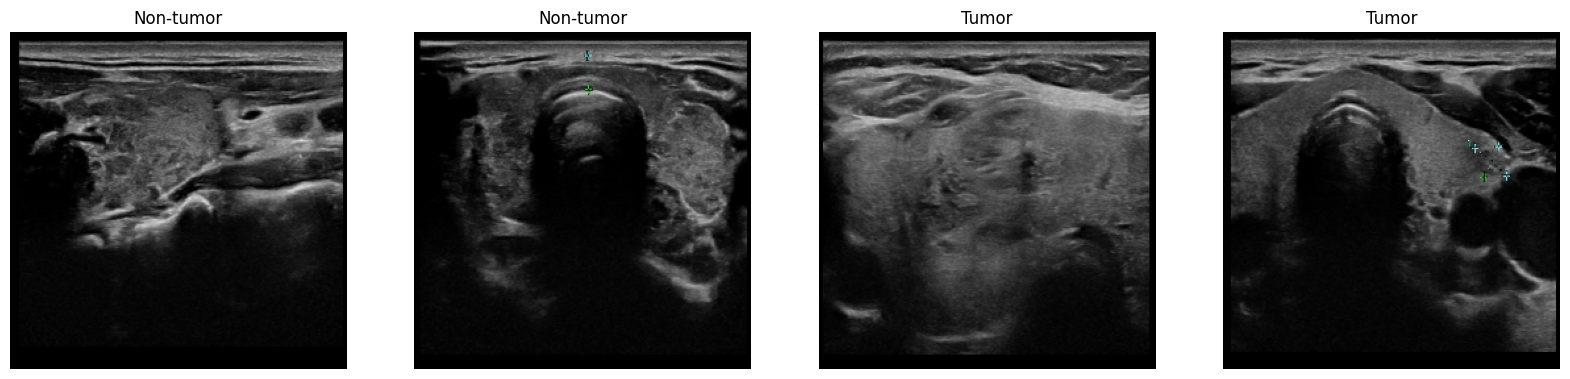

In [151]:
fig, ax = plt.subplots(1, 4, figsize = (20,5)) 
for i, img in enumerate(img_pred):
    ax[i].imshow(img)
    ax[i].axis('off')
    if pred[i] == 0:
        ax[i].set_title("Non-tumor")
    else:
        ax[i].set_title("Tumor")
for i in img_paths:
    print(i)